<center><h1 style="font-size:40px;">Regression using Recurrent Neural Networks</h1></center>


Daniel Persson - Lab 04

NOTE: If i had more time, more experimenting with the amount of hidden layer and nodes would be investigated, as well as executing more epochs for each model.

Welcome to this lab session! Today, we will be diving into the fascinating world of Recurrent Neural Networks (RNNs) and exploring their use in regression tasks.

By the end of this lab session, you will be able to:

* Understand the basic concepts behind Recurrent Neural Networks and how they work.
* Implement different architectures to include recurrent neural networks.
* Apply these RNN architectures to solve regression problems.
* Evaluate the performance of your models and understand their strengths and limitations.

In [1]:
# autoreload imports
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

!pip install numpy==1.20
!pip install opencv-python
import cv2

  Using cached numpy-1.20.0.zip (8.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [199 lines of output]
  setup.py:66: RuntimeWarning: NumPy 1.20.0 may not yet support Python 3.11.
    warnings.warn(
  Running from numpy source directory.
  setup.py:485: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    run_build = parse_setuppy_commands()
  Processing numpy/random\_bounded_integers.pxd.in
  Processing numpy/random\bit_generator.pyx
  Processing numpy/random\mtrand.pyx
  Processing numpy/random\_bounded_integers.pyx.in
  Processing numpy/random\_common.pyx
  Processing numpy/random\_generator.pyx
  Processing numpy/random\_mt19937.pyx
  Processing numpy/random\_pcg64.pyx
  Processing numpy/random\_philox.pyx
  Processing numpy/random\_sfc64.pyx
  Cythonizing sources
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying fro

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!python --version

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    device = torch.device("cuda:0")
    print(f'Using GPU: {gpu_name}')
else:
    print('GPU is not available. Using CPU.')
    torch.device("cpu")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Python 3.11.5
Using GPU: NVIDIA GeForce RTX 3080 Ti


## dataset 

In [4]:
# Convert angles to 2D vectors
def angle_to_vector_np(angles_rad):
    return np.cos(angles_rad), np.sin(angles_rad)


# Convert degrees to radians
def deg_to_rad(deg):
    return deg * np.pi / 180


# Convert radians to degrees
def rad_to_deg(rad):
    return rad * 180 / np.pi


# Convert angles to 2D vectors
def angle_to_vector(angles):
    angles_rad = deg_to_rad(angles)
    return torch.cos(angles_rad), torch.sin(angles_rad)


# Convert 2D vectors to angles
def vector_to_angle(vectors):
    return rad_to_deg(torch.atan2(vectors[1], vectors[0]))


# Convert 2D vectors to angles
def vector_to_angle_np(vectors):
    return rad_to_deg(np.arctan2(vectors[1], vectors[0]))

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def animate_datapoint(x, y):
    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Angle: {:.1f}".format(vector_to_angle_np(y)))
    ims = []
    for frame in x:
        if isinstance(frame, torch.Tensor):
            frame = frame.permute(1, 2, 0).numpy() * 255
        im = plt.imshow(frame.astype(np.uint8))
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    return ani


def animate_datapoint_with_direction(x, y, center, pred=None, pred_color="red"):
    """
    This function creates an animation of a data point with a direction arrow. Use this function to visualize the data points in the training, validation, and test sets.
    You can also use this function to visualize the predictions of your model, by providing the predicted direction vector as the `pred` parameter.
    In case the object color is interfering with the visibility of the direction arrow, you can change the color of the predicted direction arrow using the `pred_color` parameter.

    Parameters:
    x (array-like or torch.Tensor): The frames to be animated. If frames are torch.Tensor, they will be converted to numpy arrays.
    y (array-like): The direction vector for the arrow in the animation.
    center (tuple): The starting point (center) of the arrow.
    pred (array-like, optional): The predicted direction vector for the arrow in the animation. If provided, an additional arrow showing the predicted direction will be drawn. Defaults to None.
    pred_color (str, optional): The color of the predicted direction arrow. Defaults to "red".

    Returns:
    matplotlib.animation.ArtistAnimation: The resulting animation object.
    """

    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title("Angle: {:.1f}".format(vector_to_angle_np(y)))

    ims = []
    for frame in x:
        if isinstance(frame, torch.Tensor):
            frame = frame.permute(1, 2, 0).numpy() * 255
        im = plt.imshow(frame.astype(np.uint8))
        arrow = plt.arrow(
            center[0],
            center[1],
            y[0] * 4,
            y[1] * -4,
            head_width=3,
            head_length=5,
            fc="black",
            ec="black",
        )
        if pred is not None:
            arrow_pred = plt.arrow(
                center[0],
                center[1],
                pred[0] * 4,
                pred[1] * -4,
                head_width=3,
                head_length=5,
                fc=pred_color,
                ec=pred_color,
            )
            ims.append([im, arrow, arrow_pred])
        else:
            ims.append([im, arrow])

    ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
    return ani

In [6]:
def generate_dataset(
    num_samples,
    canvas_size=(64, 64),
    shapes=["circle", "triangle", "square"],
    colors={
        "blue": (255, 0, 0),
        "yellow": (0, 255, 255),
        "red": (0, 0, 255),
        "gray": (128, 128, 128),
        "green": (0, 255, 0),
        "purple": (255, 0, 255),
    },
):
    """
    Generates a dataset of random shapes moving in a straight line in random directions.

    Parameters:
    num_samples (int): The number of samples to generate.
    canvas_size (tuple): The size of the canvas for each sample. Defaults to (64, 64).
    shapes (list): The shapes to be used in the dataset. Defaults to ["circle", "triangle", "square"].
    num_frames (int): The number of frames for each sample. Defaults to 30.
    colors (dict): The colors to be used for the shapes. Defaults to a dictionary of BGR color values.
    step_size (float): The step size for the movement of the shapes. Defaults to 0.5.

    Returns:
    tuple: A tuple containing the following elements:
        - dataset (numpy.ndarray): The generated dataset. Shape is (num_samples, num_frames, canvas_size[0], canvas_size[1], 3).
        - labels (numpy.ndarray): The labels for each sample. Shape is (num_samples,).
        - centers (list): The center positions for each shape.
    """

    labels_list = []
    centers_list = []
    shapes_list = []
    angles_deg_list = []
    sizes_list = []
    colors_list = []

    for i in range(num_samples):
        shape = np.random.choice(shapes)
        position = np.random.rand(2) * (np.array(canvas_size) - 1)
        size = np.random.randint(4, 10)
        angle_deg = np.random.uniform(0, 360)
        angle_rad = np.radians(angle_deg)
        color = colors[np.random.choice(list(colors.keys()))]
        colors_list.append(color)

        labels_list.append(angle_to_vector_np(angle_rad))
        centers_list.append(position.copy())
        shapes_list.append(shape)
        angles_deg_list.append(angle_deg)
        sizes_list.append(size)

    return (
        labels_list,
        centers_list,
        shapes_list,
        angles_deg_list,
        sizes_list,
        colors_list,
    )


def generate_frames(
    num_frames,
    center,
    angle_deg,
    canvas_size,
    shape,
    size,
    color,
    step_size=0.5,
):
    frames = np.zeros((num_frames, canvas_size[0], canvas_size[1], 3))
    angle_rad = np.radians(angle_deg)
    direction = np.array([np.cos(angle_rad), -np.sin(angle_rad)]) * step_size

    center = center.copy()

    for i in range(num_frames):
        canvas = np.ones((canvas_size[0], canvas_size[1], 3), dtype=np.uint8) * 255

        if shape == "circle":
            cv2.circle(canvas, tuple(center.astype(int)), size, color, -1)
        elif shape == "triangle":
            points = np.array(
                [
                    [center[0], center[1]],
                    [center[0] + size, center[1]],
                    [center[0] + size // 2, center[1] - size],
                ]
            )
            points = points.reshape((-1, 1, 2)).astype(int)
            cv2.fillPoly(canvas, [points], color=color)
        elif shape == "square":
            top_left = (int(center[0] - size // 2), int(center[1] - size // 2))
            bottom_right = (int(center[0] + size // 2), int(center[1] + size // 2))
            cv2.rectangle(canvas, top_left, bottom_right, color, -1)

        frames[i] = canvas

        # Update the center based on the direction and step size.
        center += direction

    return frames

In [7]:
class MovingShapesDataset(Dataset):
    def __init__(self, num_samples, num_frames, transform=None, canvas_size=(64, 64)):
        self.num_samples = num_samples
        self.num_frames = num_frames
        self.canvas_size = canvas_size
        (
            self.labels,
            self.centers,
            self.shapes,
            self.angles_deg,
            self.sizes,
            self.colors,
        ) = generate_dataset(num_samples)

        self.transform = transform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label, center, shape, angle_deg, size, color = (
            self.labels[idx],
            self.centers[idx],
            self.shapes[idx],
            self.angles_deg[idx],
            self.sizes[idx],
            self.colors[idx],
        )
        frames = generate_frames(
            self.num_frames, center, angle_deg, self.canvas_size, shape, size, color
        )
        frames = torch.from_numpy(frames).float() / 255.0
        if self.transform:
            frames, label = self.transform((frames, label))
        return (
            frames.permute(0, 3, 1, 2),
            np.array(label),
            center,
        )  # center is added for plotting purposes, you are not allowed to use it in the network

In [8]:
train_dataset = MovingShapesDataset(num_samples=50000, num_frames=20)
val_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)
test_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)

for i in range(10):
    frames, labels, _ = val_dataset[i]
    print(f"datasample {i + 1}: Label {i + 1} --> {labels[:10]}")
    
sample = train_dataset[0]
frames = sample[0]
print(frames.shape)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

datasample 1: Label 1 --> [0.21063429 0.97756493]
datasample 2: Label 2 --> [-0.67930281  0.73385809]
datasample 3: Label 3 --> [ 0.22033784 -0.97542362]
datasample 4: Label 4 --> [-0.88254273  0.4702322 ]
datasample 5: Label 5 --> [0.89942564 0.4370738 ]
datasample 6: Label 6 --> [0.13760883 0.99048665]
datasample 7: Label 7 --> [-0.26999028  0.96286305]
datasample 8: Label 8 --> [ 0.84464316 -0.53532974]
datasample 9: Label 9 --> [-0.8488492   0.52863507]
datasample 10: Label 10 --> [-0.24104125 -0.97051487]
torch.Size([20, 3, 64, 64])


In [9]:
index = random.randint(0, len(train_dataset) - 1)
sample_data, sample_label, sample_initial_position = train_dataset[index]

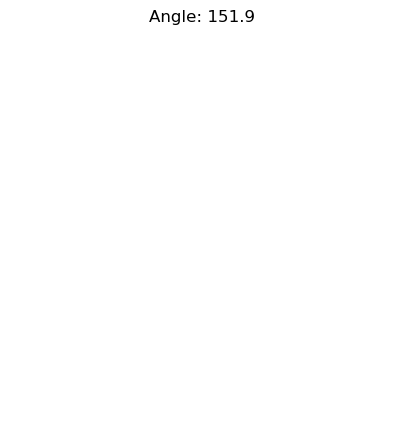

In [10]:
ani = animate_datapoint_with_direction(
    sample_data, sample_label, sample_initial_position, pred=(0.5, 0)
)
HTML(ani.to_jshtml())

## TASK 1

#TODO Define CNN model to predict the angle of movement. You are encouraged to use the models from torchvision. You can also use the models from the previous lab. Do not forget to change the output layer dimension. And using the proper training scripts from the previous labs, train the model. How the model is doing? 

A: The model is doing alright by hanging around at  0.0075- 0.008. However, it takes a lot of time to train this CNN network.

In [11]:
resnet18 = models.resnet18(pretrained = True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

class ResNetCNN(nn.Module):
    def __init__(self, original_model):
        super(ResNetCNN, self).__init__()
        self.resnet = original_model

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()
        x = x.view(batch_size * seq_length, C, H, W) 
        x = self.resnet(x) 
        x = x.view(batch_size, seq_length, -1)
        x = x.mean(dim=1)
        return x

C:\Users\danie\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\danie\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    
    train_losses = []
    val_losses = []
    #hej = 0
    #hej2 = 0
    
    print("Data:", len(train_dataset))
    print("Epochs:",num_epochs)
    print("Start of training.")
    for epoch in range(num_epochs):
        # Part 1, training
        model.train()
        epoch_loss = 0.0
        #total_samples = 0
        for batch_idx, batch in enumerate(train_loader):
            #hej = hej+1
            #print(hej)
            
            images, labels = batch[0].float().to(device), batch[1].float().to(device)
            images, labels = images.to(device), labels.to(device)
            #print(batch)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #print(loss.item())
            epoch_loss += loss.item()
            #total_samples += labels.size(0)

        average_loss = epoch_loss / len(train_dataset)
        train_losses.append(average_loss)

        # Part 2, validation
        model.eval()
        val_loss = 0.0
        #total_val_samples = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                #hej2 = hej2+1
                #print(hej2)
            
                images, labels = batch[0].float().to(device), batch[1].float().to(device)
                images, labels = images.to(device), labels.to(device)
                #print(batch)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                #print(loss.item())
                val_loss += loss.item()
                #total_val_samples += labels.size(0)

        average_val_loss = val_loss / len(val_dataset)
        val_losses.append(average_val_loss)

        print(f"Epoch: {epoch + 1}/{num_epochs} --> "f"Training Loss / per sample = {average_loss:.10f}, Validation Loss / per sample = {average_val_loss:.10f}")
    print("End of training.")
    
    #print(train_losses)
    #print(val_losses)
    
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)

    print("Lowest Training Loss:", min_train_loss)
    print("Lowest Validation Loss:", min_val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses over {} epochs (CNN)'.format(num_epochs))
    plt.gca().set_facecolor('black')
    plt.show()


Data: 50000
Epochs: 5
Start of training.
Epoch: 1/5 --> Training Loss / per sample = 0.0079136072, Validation Loss / per sample = 0.0077314441
Epoch: 2/5 --> Training Loss / per sample = 0.0073015676, Validation Loss / per sample = 0.0077770241
Epoch: 3/5 --> Training Loss / per sample = 0.0073041535, Validation Loss / per sample = 0.0079473987
Epoch: 4/5 --> Training Loss / per sample = 0.0073158896, Validation Loss / per sample = 0.0078624637
Epoch: 5/5 --> Training Loss / per sample = 0.0072753428, Validation Loss / per sample = 0.0074522467
End of training.
Lowest Training Loss: 0.0072753428333997726
Lowest Validation Loss: 0.00745224666595459


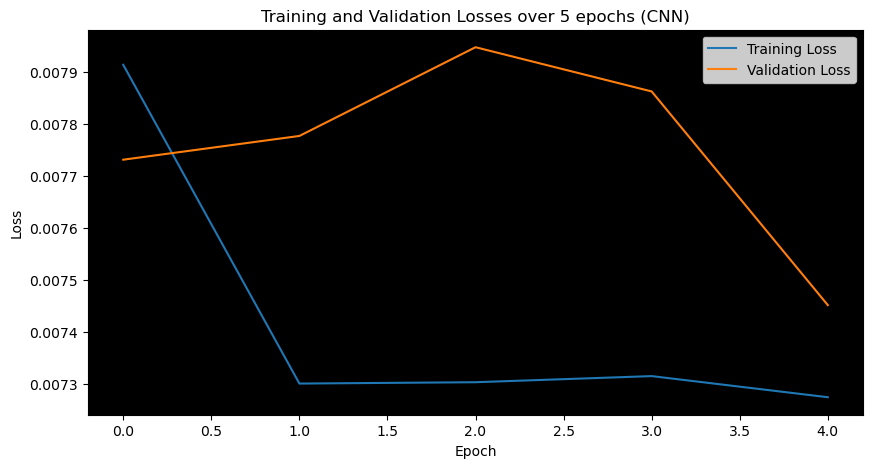

In [13]:
my_model = ResNetCNN(resnet18)
my_model.to(device)

optimizer = optim.Adam(my_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train(my_model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

## TASK 2

#TODO Define Recurrent neural network model to predict the angle of movement. And using the proper training scripts from the previous labs, train the model. How the model is doing? 

A: Here the LSTM-model is also doing alright by convering at around 0.008, like the CNN. But in this case with the LSTM, a lot less data is needed for it to converge, and the LSTM is also a lot quicker than the CNN network and still yielding the same results.

You can have a look at the following skeleton of a basic recurrent model in pytorch. Keep mind that is just a basic starting point. Have look at the [pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and adding more layers, dropout, bidirectionality and so on

In [14]:
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional=False, dropout=0.0):
        super(ComplexLSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        
        if self.bidirectional:
            self.fc = nn.Linear(self.hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(self.hidden_size * 1, output_size)
        
    def forward(self, x):
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        else:
            h0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(x.device)
        output, _ = self.lstm(x, (h0, c0))
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])
        return output

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    train_losses = [] 
    val_losses = []  
    #hej = 0
    #hej2 = 0
    
    print("Data:", len(train_dataset))
    print("Epochs:",num_epochs)
    print("Start of training.")
    for epoch in range(num_epochs):
        # Part 1, training
        model.to(device)  
        model.train()
        train_loss = 0.0
        #total_samples = 0 
        for batch_idx, (frames, labels, _) in enumerate(train_loader):
            #hej = hej+1
            #print(hej)
            
            frames, labels = frames.to(device).float(), labels.to(device).float()
            frames = frames.reshape(frames.size(0), -1, frames.size(4))
            #print(batch)
            
            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #print(loss.item())
            train_loss += loss.item()
            #total_samples += labels.size(0) 

        average_loss = train_loss / len(train_dataset)
        train_losses.append(average_loss)

        # Validation section
        model.eval()
        val_loss = 0.0
        #total_val_samples = 0 
        with torch.no_grad():
            for batch_idx, (frames, labels, _) in enumerate(val_loader):
                #hej2 = hej2+1
                #print(hej2)
                
                frames, labels = frames.to(device).float(), labels.to(device).float()
                frames = frames.reshape(frames.size(0), -1, frames.size(4))
                #print(batch)
                
                outputs = model(frames)
                loss = criterion(outputs, labels)
                
                #print(loss.item())
                val_loss += loss.item()
                #total_val_samples += labels.size(0)

        average_val_loss = val_loss / len(val_dataset)
        val_losses.append(average_val_loss) 

        print(f"Epoch: {epoch + 1}/{num_epochs} --> "f"Training Loss / per sample = {average_loss:.10f}, Validation Loss / per sample = {average_val_loss:.10f}")
    print("End of training.")
    
    #print(train_losses)
    #print(val_losses)
    
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)

    print("Lowest Training Loss:", min_train_loss)
    print("Lowest Validation Loss:", min_val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses over {} epochs (LSTM)'.format(num_epochs))
    plt.gca().set_facecolor('black')
    plt.show()


Data: 50000
Epochs: 5
Start of training.
Epoch: 1/5 --> Training Loss / per sample = 0.0078323322, Validation Loss / per sample = 0.0079959818
Epoch: 2/5 --> Training Loss / per sample = 0.0078228315, Validation Loss / per sample = 0.0079929460
Epoch: 3/5 --> Training Loss / per sample = 0.0078059993, Validation Loss / per sample = 0.0079762558
Epoch: 4/5 --> Training Loss / per sample = 0.0077809593, Validation Loss / per sample = 0.0079295930
Epoch: 5/5 --> Training Loss / per sample = 0.0077642148, Validation Loss / per sample = 0.0080174292
End of training.
Lowest Training Loss: 0.007764214782118797
Lowest Validation Loss: 0.00792959302663803


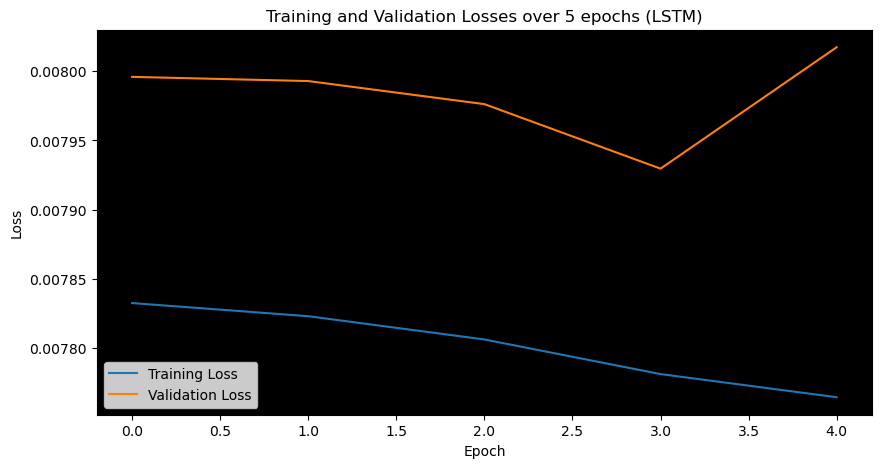

In [16]:
input_size = 64
hidden_size = 64
output_size = 2
num_layers = 2
bidirectional = True
dropout = 0.2

model = ComplexLSTMModel(input_size, hidden_size, output_size, num_layers, bidirectional, dropout)
model.to(device)

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

### TASK 3

#TODO Define a CNN + LSTM model to predict the angle of movement. You should do so by passing the features learned from the CNN model you have defined to LSTM module. In another words, you can insert a LSTM layer in between the conv layers and fully connected layers in the CNN model you have defined. This should learn the temporal features in between the frames. Does this model achieve better results?

A: As for the CNN + LSTM, the time it takes to train is somewhat in the middle of what it took for the CNN and the LSTM individually. And as we can see from the plotted information below, the cnn + lstm combination is outperforming the lstm and cnn individually by a good margin. Reaching a low of 0.00019 loss for training and a loss of 0.00013 for validation. I think it is because when combining them, we take the best out of the "2 worlds" and put em together.

In [17]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

class CNNLSTMModel(nn.Module):
    def __init__(self, cnn_model, lstm_hidden_size, num_lstm_layers, output_size):
        super(CNNLSTMModel, self).__init__()
        self.cnn = cnn_model  
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm = nn.LSTM(input_size=2, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size *2, output_size)

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()
        x = x.view(batch_size * seq_length, C, H, W)
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(batch_size, seq_length, -1)
        
        h0 = torch.zeros(self.num_lstm_layers *2, batch_size, self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers *2, batch_size, self.lstm_hidden_size).to(x.device)
        
        lstm_output, _ = self.lstm(cnn_features, (h0, c0))
        lstm_output = lstm_output[:, -1, :]
        output = self.fc(lstm_output)
        return output

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    
    train_losses = [] 
    val_losses = []  
    #hej = 0
    #hej2 = 0
    
    print("Data:", len(train_dataset))
    print("Epochs:",num_epochs)
    print("Start of training.")
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        #total_samples = 0 
        for batch_idx, batch in enumerate(train_loader):
            #hej = hej+1
            #print(hej)
            
            images, labels = batch[0].float().to(device), batch[1].float().to(device)
            images, labels = images.to(device), labels.to(device)
            #print(batch)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            #print(loss.item())
            train_loss += loss.item()
            #total_samples += labels.size(0) 

        average_loss = train_loss / len(train_dataset)
        train_losses.append(average_loss) 

        # Validation
        model.eval()
        val_loss = 0.0
        #total_val_samples = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                #hej2 = hej2+1
                #print(hej2)
                
                images, labels = batch[0].float().to(device), batch[1].float().to(device)
                images, labels = images.to(device), labels.to(device)
                #print(batch)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                #print(loss.item())
                val_loss += loss.item()
                #total_val_samples += labels.size(0)

        average_val_loss = val_loss / len(val_dataset)
        val_losses.append(average_val_loss) 

        print(f"Epoch: {epoch + 1}/{num_epochs} --> "f"Training Loss / per sample = {average_loss:.10f}, Validation Loss / per sample = {average_val_loss:.10f}")
    print("End of training.")
    
    #print(train_losses)
    #print(val_losses)
    
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)

    print("Lowest Training Loss:", min_train_loss)
    print("Lowest Validation Loss:", min_val_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses over {} epochs (LSTM+CNN)'.format(num_epochs))
    plt.gca().set_facecolor('black')
    plt.show()

Data: 50000
Epochs: 5
Start of training.
Epoch: 1/5 --> Training Loss / per sample = 0.0046756418, Validation Loss / per sample = 0.0006404271
Epoch: 2/5 --> Training Loss / per sample = 0.0004247573, Validation Loss / per sample = 0.0002530297
Epoch: 3/5 --> Training Loss / per sample = 0.0003163243, Validation Loss / per sample = 0.0002363395
Epoch: 4/5 --> Training Loss / per sample = 0.0003124997, Validation Loss / per sample = 0.0001364994
Epoch: 5/5 --> Training Loss / per sample = 0.0001900481, Validation Loss / per sample = 0.0001862587
End of training.
Lowest Training Loss: 0.00019004812228493392
Lowest Validation Loss: 0.00013649942586198448


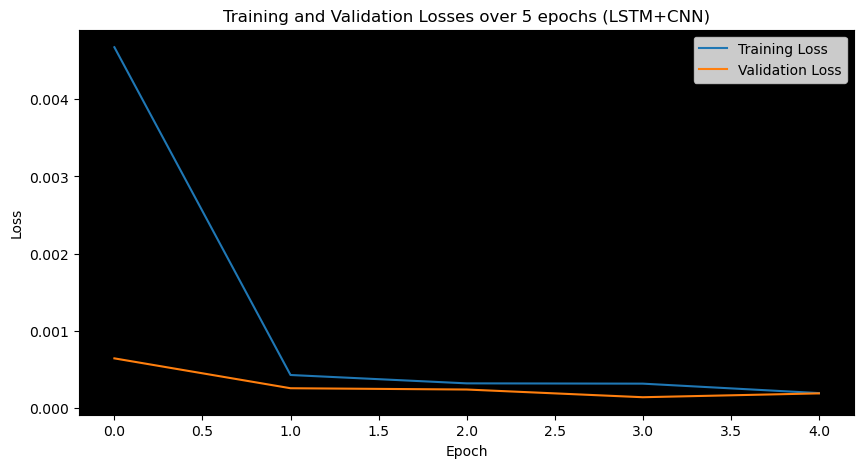

In [19]:
cnn_lstm_model = CNNLSTMModel(resnet18, lstm_hidden_size=64, num_lstm_layers=2, output_size=2)
cnn_lstm_model.to(device)

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

train(cnn_lstm_model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

## TASK 4

#TODO Define a ConvLSTM model to predict the angle of movement. You should have a look at the lecture to refresh your memory on the mechanisms behind this. Does this model achieve better results? 

It did not have better results than the CNNLSTMModel implemented in task 3. However, the model in task 4 was trained with 1 layer and 8 hidden neurons instead of 2 layers and 64 hidden nodes like the models from task 3,2, and 1. This because i had a bit of a time constraint and i couldnt train it with the same amount and hand it in in time. This probably affected the training and validation, as well as the batch size being 8 instead of 64.

A: If we disregard from the fact that it has a different amount of layers and neurons we can see that it performed the worst out of all 4 models, which sounds wierd. It was also very computationally intensive, taking the longest time out of all models even with the lowest amount of hidden layers and neurons.

We have included an [implementation of the ConvLSTM](https://github.com/ndrplz/ConvLSTM_pytorch/tree/master) for the convenience. You can use this as a building block in your ConvLSTM model

In [20]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat(
            [input_tensor, h_cur], dim=1
        )  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
        )


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(
        self,
        input_dim,
        hidden_dim,
        kernel_size,
        num_layers,
        batch_first=False,
        bias=True,
        return_all_layers=False,
    ):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (
            isinstance(kernel_size, tuple)
            or (
                isinstance(kernel_size, list)
                and all([isinstance(elem, tuple) for elem in kernel_size])
            )
        ):
            raise ValueError("`kernel_size` must be tuple or list of tuples")

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [21]:
class teachersConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(teachersConvLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.convlstm = ConvLSTM(input_dim=input_size,
                                 hidden_dim=hidden_size,
                                 kernel_size=(3, 3),
                                 num_layers=num_layers,
                                 batch_first=True)
        self.fc = nn.LazyLinear(output_size)

    def forward(self, x):
        batch_nr = x.size(0)
        output = self.convlstm(x)[0]
        output = output[0][:, -1, :, :, :] 
        output = output.view(batch_nr, -1)
        output = self.fc(output)
        return output

Data: 50000
Epochs: 5
Start of training.


C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 2])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/5 --> Training Loss / per sample = 0.0618760321, Validation Loss / per sample = 0.0605923868
Epoch: 2/5 --> Training Loss / per sample = 0.0425335859, Validation Loss / per sample = 0.0322998884
Epoch: 3/5 --> Training Loss / per sample = 0.0575849980, Validation Loss / per sample = 0.0580314798
Epoch: 4/5 --> Training Loss / per sample = 0.0506614391, Validation Loss / per sample = 0.0325079166
Epoch: 5/5 --> Training Loss / per sample = 0.0320223443, Validation Loss / per sample = 0.0322788427
End of training.
Lowest Training Loss: 0.03202234428308904
Lowest Validation Loss: 0.032278842657804487


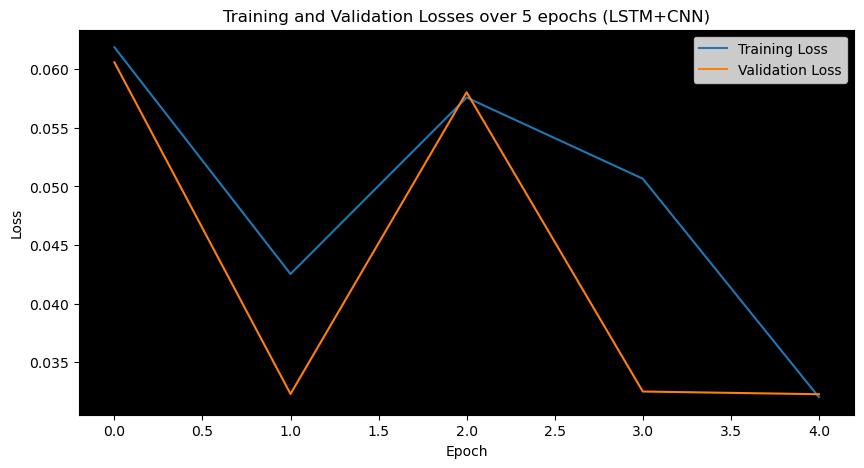

In [23]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

output_size = 2
hidden_size = 8
input_size = 3
num_layers = 1

model = teachersConvLSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

## TASK 5 (Bonus)

Let's spice things a little bit. In this task, we are corrupting the dataset, by adding random amount of static shapes to the background. 

#TODO Use the model with the best performance you have achieved in the previous models, to tackle this problem. how is the performance? is retraining on the trainset of this corrupted dataset helps?

In [ ]:
def generate_dataset_with_static_shapes(
    num_samples,
    canvas_size=(64, 64),
    shapes=["circle", "triangle", "square"],
    colors={
        "blue": (255, 0, 0),
        "yellow": (0, 255, 255),
        "red": (0, 0, 255),
        "gray": (128, 128, 128),
        "green": (0, 255, 0),
        "purple": (255, 0, 255),
    },
):
    """
    Generates a dataset of random shapes moving in a straight line in random directions.

    Parameters:
    num_samples (int): The number of samples to generate.
    canvas_size (tuple): The size of the canvas for each sample. Defaults to (64, 64).
    shapes (list): The shapes to be used in the dataset. Defaults to ["circle", "triangle", "square"].
    num_frames (int): The number of frames for each sample. Defaults to 30.
    colors (dict): The colors to be used for the shapes. Defaults to a dictionary of BGR color values.
    step_size (float): The step size for the movement of the shapes. Defaults to 0.5.

    Returns:
    tuple: A tuple containing the following elements:
        - dataset (numpy.ndarray): The generated dataset. Shape is (num_samples, num_frames, canvas_size[0], canvas_size[1], 3).
        - labels (numpy.ndarray): The labels for each sample. Shape is (num_samples,).
        - centers (list): The center positions for each shape.
    """

    labels_list = []
    centers_list = []
    shapes_list = []
    angles_deg_list = []
    sizes_list = []
    colors_list = []
    static_shapes_info_list = []

    for i in range(num_samples):
        shape = np.random.choice(shapes)
        position = np.random.rand(2) * (np.array(canvas_size) - 1)
        size = np.random.randint(4, 10)
        angle_deg = np.random.uniform(0, 360)
        angle_rad = np.radians(angle_deg)
        color = colors[np.random.choice(list(colors.keys()))]

        num_static_shapes = np.random.randint(1, 5)
        static_shapes_info = []
        for _ in range(num_static_shapes):
            static_shape_info = {
                "shape": np.random.choice(shapes),
                "position": np.random.rand(2) * (np.array(canvas_size) - 1),
                "size": np.random.randint(4, 10),
                "color": colors[np.random.choice(list(colors.keys()))],
            }
            static_shapes_info.append(static_shape_info)

        colors_list.append(color)
        labels_list.append(angle_to_vector_np(angle_rad))
        centers_list.append(position.copy())
        shapes_list.append(shape)
        angles_deg_list.append(angle_deg)
        sizes_list.append(size)
        static_shapes_info_list.append(static_shapes_info)

    return (
        labels_list,
        centers_list,
        shapes_list,
        angles_deg_list,
        sizes_list,
        colors_list,
        static_shapes_info_list,
    )


def generate_frames_with_static_shapes(
    num_frames,
    center,
    angle_deg,
    canvas_size,
    shape,
    size,
    color,
    static_shapes_info,
    step_size=0.5,
):
    frames = np.zeros((num_frames, canvas_size[0], canvas_size[1], 3))
    angle_rad = np.radians(angle_deg)
    direction = np.array([np.cos(angle_rad), -np.sin(angle_rad)]) * step_size

    center = center.copy()

    for i in range(num_frames):
        canvas = np.ones((canvas_size[0], canvas_size[1], 3), dtype=np.uint8) * 255

        # add static shapes
        for static_shape_info in static_shapes_info:
            static_shape = static_shape_info["shape"]
            static_position = static_shape_info["position"]
            static_size = static_shape_info["size"]
            static_color = static_shape_info["color"]

            if static_shape == "circle":
                cv2.circle(
                    canvas,
                    tuple(static_position.astype(int)),
                    static_size,
                    static_color,
                    -1,
                )
            elif static_shape == "triangle":
                points = np.array(
                    [
                        [static_position[0], static_position[1]],
                        [static_position[0] + static_size, static_position[1]],
                        [
                            static_position[0] + static_size // 2,
                            static_position[1] - static_size,
                        ],
                    ]
                )
                points = points.reshape((-1, 1, 2)).astype(int)
                cv2.polylines(
                    canvas, [points], isClosed=True, color=static_color, thickness=2
                )
            elif static_shape == "square":
                top_left = (
                    int(static_position[0] - static_size // 2),
                    int(static_position[1] - static_size // 2),
                )
                bottom_right = (
                    int(static_position[0] + static_size // 2),
                    int(static_position[1] + static_size // 2),
                )
                cv2.rectangle(canvas, top_left, bottom_right, static_color, -1)

        if shape == "circle":
            cv2.circle(canvas, tuple(center.astype(int)), size, color, -1)
        elif shape == "triangle":
            points = np.array(
                [
                    [center[0], center[1]],
                    [center[0] + size, center[1]],
                    [center[0] + size // 2, center[1] - size],
                ]
            )
            points = points.reshape((-1, 1, 2)).astype(int)
            cv2.fillPoly(canvas, [points], color=color)
        elif shape == "square":
            top_left = (int(center[0] - size // 2), int(center[1] - size // 2))
            bottom_right = (int(center[0] + size // 2), int(center[1] + size // 2))
            cv2.rectangle(canvas, top_left, bottom_right, color, -1)

        frames[i] = canvas

        # Update the center based on the direction and step size.
        center += direction

    return frames

In [ ]:
class MovingShapesDataset(Dataset):
    def __init__(self, num_samples, num_frames, transform=None, canvas_size=(64, 64)):
        self.num_samples = num_samples
        self.num_frames = num_frames
        self.canvas_size = canvas_size
        (
            self.labels,
            self.centers,
            self.shapes,
            self.angles_deg,
            self.sizes,
            self.colors,
            self.static_shapes_info,
        ) = generate_dataset_with_static_shapes(num_samples)

        self.transform = transform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label, center, shape, angle_deg, size, color, static_shapes_info = (
            self.labels[idx],
            self.centers[idx],
            self.shapes[idx],
            self.angles_deg[idx],
            self.sizes[idx],
            self.colors[idx],
            self.static_shapes_info[idx],
        )
        frames = generate_frames_with_static_shapes(
            self.num_frames,
            center,
            angle_deg,
            self.canvas_size,
            shape,
            size,
            color,
            static_shapes_info,
        )
        frames = torch.from_numpy(frames).float() / 255.0
        if self.transform:
            frames, label = self.transform((frames, label))
        return (
            frames.permute(0, 3, 1, 2),
            np.array(label),
            center,
        )  # center is added for plotting purposes, you are not allowed to use it in the network

In [ ]:
train_dataset = MovingShapesDataset(num_samples=100000, num_frames=20)
val_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)
test_dataset = MovingShapesDataset(num_samples=1000, num_frames=20)

In [ ]:
index = random.randint(0, len(train_dataset) - 1)
sample_date, sample_label, sample_initial_position = train_dataset[index]

In [ ]:
ani = animate_datapoint_with_direction(
    sample_date, sample_label, sample_initial_position
)
HTML(ani.to_jshtml())

## TASK 6 (BONUS)

#TODO! As you have seen in the previous lab, augmenting the data can help improve the performance of the model.
Can you think of a way to augment the data in this case? Implement it and see if it helps improve the performance of the model.
Keep in mind that the labels must be augmented in the same way as the images.